Transfer Learning with a CNN
======================================

This notebook has been adapted from the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
Similar to the original tutorial, this one will demonstrate two different variations of transfer learning.

As discussed in class, __[transfer learning](https://en.wikipedia.org/wiki/Transfer_learning)__ in machine learning is about utilizing an already-trained model for your specific problem or use case.

Large neural networks can take a significant amount of resources to train, in terms of long training time,
massive dataset size, and costly computer hardware. Given that, it's
no surprise that we would want to avoid training a model from scratch. This is where transfer learning comes in.

Transfer learning starts by taking a pre-trained neural network model that was trained to, say, predict which of
1000 possible types of animals is in an image. This model is then used/repurposed/recycled to, say, predict which of two animals
is in an image. Note that two types of animals that you want to perform classification on don't even need to be part of the original 1000 animals.

There are two types of transfer learning techniques we'll try. Technically, we will be using the exact same model architecture with the pre-trained parameters, but they will be different instances of the model. We will refer to them as Approach A and Approach B. The differences are:

-   **Approach A: Finetuning the ConvNet** - Start with the pre-trained model, change the final output layer to have only 2 units (or neurons), and then fine-tune or refit the model on our Ant and Bee images. All the parameter values can change.
-   **Approach B: ConvNet as fixed feature extractor** - Again, start with the pre-trained model, change the final output layer to have only 2 units (or neurons), but this time only allow the parameter values in the (new) final layer to be modified.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MSU-CS3120/transfer_learning/blob/main/transfer_learning.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/MSU-CS3120/transfer_learning/blob/main/transfer_learning.ipynb)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
!git clone https://github.com/sgeinitz/CS3120.git

fatal: destination path 'CS3120' already exists and is not an empty directory.


Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class.

Trying to train a deep learning model from scratch with just one or two hundred images is not really possible.
But, we're not going to train the deep learning model from scratch. Instead, we're going to use one that was already trained on millions
of images to classify which of one-thousand (1000) possible categories the contents of the image falls into.
We'll then going to fine tune the model for our specific problem of binary classification, namely: Bee or Ant (i.e, not Bee)).

Since we are using transfer learning, and *not* training the model from scratch, one or two hundred images is plenty.



NOTE: This is where `batch_size` is size (technically speaking, we're talking about the mini-batch size). Questions 3 and 4 below will ask you to come back
and change this, but wait until you've run it one time with `batch_size=16` before changing it.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CS3120/lab4_transfer_learning_images/hymenoptera'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# check for a GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# check for an Apple MPS device
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# otherwise use the CPU
else:
    device = torch.device("cpu")

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda:0


Examine a few Images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.

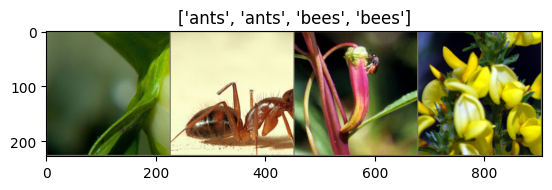

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model.

Notice that in addition to using mini-batches, there is another so-called _trick_ we're using. Namely, the use
of a __scheduler__ to modify the learning rate over time.

In the following, parameter `scheduler` is a LR scheduler object from
`torch.optim.lr_scheduler`. Right now it is only a a parameter in the `train_model` function, but you will see
it declared/instantiated later on in this notebook.


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    b_losses = {'train':[], 'val':[]}
    e_losses = {'train':[], 'val':[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print('-' * 10)
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Approach A: Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.

This is also where we create instances of the `optimizer` and `scheduler` objects, both of which are then passed into
the `train_model` function as parameters.

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# In general, this could be written as ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

This will take 1-2 minutes on a GPU, or around 20-25 minutes with a CPU.


In [8]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6876 Acc: 0.6844
----------
val Loss: 0.4734 Acc: 0.8562

Epoch 1/24

Epoch 2/24

Epoch 3/24

Epoch 4/24
----------
train Loss: 0.5547 Acc: 0.8033
----------
val Loss: 0.3051 Acc: 0.8954

Epoch 5/24

Epoch 6/24

Epoch 7/24

Epoch 8/24
----------
train Loss: 0.2274 Acc: 0.9180
----------
val Loss: 0.2062 Acc: 0.9085

Epoch 9/24

Epoch 10/24

Epoch 11/24

Epoch 12/24
----------
train Loss: 0.2961 Acc: 0.8607
----------
val Loss: 0.2208 Acc: 0.8824

Epoch 13/24

Epoch 14/24

Epoch 15/24

Epoch 16/24
----------
train Loss: 0.2321 Acc: 0.9016
----------
val Loss: 0.2179 Acc: 0.9020

Epoch 17/24

Epoch 18/24

Epoch 19/24

Epoch 20/24
----------
train Loss: 0.2568 Acc: 0.8811
----------
val Loss: 0.2131 Acc: 0.9020

Epoch 21/24

Epoch 22/24

Epoch 23/24

Epoch 24/24
----------
train Loss: 0.2781 Acc: 0.8770
----------
val Loss: 0.2528 Acc: 0.8758

Training complete in 1m 13s
Best val Acc: 0.921569


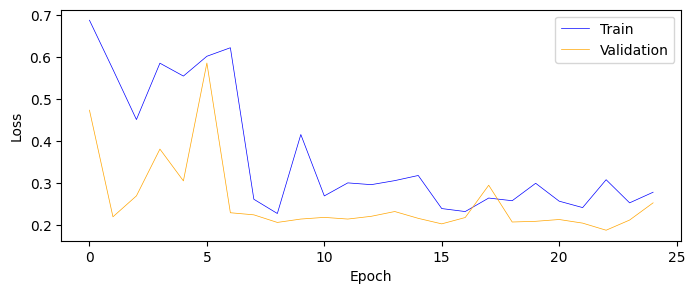

In [9]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

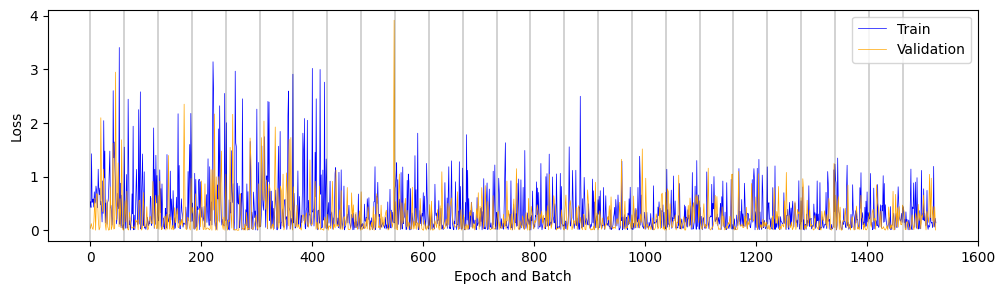

In [10]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

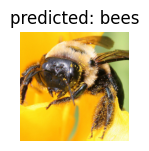

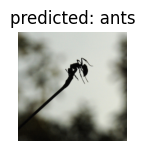

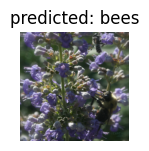

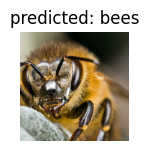

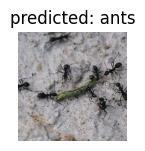

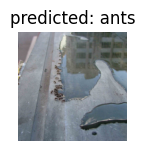

In [11]:
visualize_model(model_ft)

Approach B: ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [12]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

Now use `train_model` again, but with the above model object, which has frozen all the parameters except for those in the final layer.

***
### Q1: Will this run faster or slower than the earlier training run? Explain why or why not?

B runs faster because freezing the pretrained layers means PyTorch skips computing gradients for them.

***

In [13]:
model_conv, epoch_losses, batch_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6779 Acc: 0.6393
----------
val Loss: 0.4029 Acc: 0.8039

Epoch 1/24

Epoch 2/24

Epoch 3/24

Epoch 4/24
----------
train Loss: 0.6724 Acc: 0.7008
----------
val Loss: 0.2679 Acc: 0.9150

Epoch 5/24

Epoch 6/24

Epoch 7/24

Epoch 8/24
----------
train Loss: 0.4218 Acc: 0.8320
----------
val Loss: 0.2062 Acc: 0.9412

Epoch 9/24

Epoch 10/24

Epoch 11/24

Epoch 12/24
----------
train Loss: 0.3736 Acc: 0.8238
----------
val Loss: 0.2083 Acc: 0.9477

Epoch 13/24

Epoch 14/24

Epoch 15/24

Epoch 16/24
----------
train Loss: 0.3090 Acc: 0.8770
----------
val Loss: 0.1855 Acc: 0.9477

Epoch 17/24

Epoch 18/24

Epoch 19/24

Epoch 20/24
----------
train Loss: 0.3044 Acc: 0.8934
----------
val Loss: 0.1887 Acc: 0.9477

Epoch 21/24

Epoch 22/24

Epoch 23/24

Epoch 24/24
----------
train Loss: 0.3218 Acc: 0.8484
----------
val Loss: 0.1998 Acc: 0.9477

Training complete in 1m 4s
Best val Acc: 0.947712


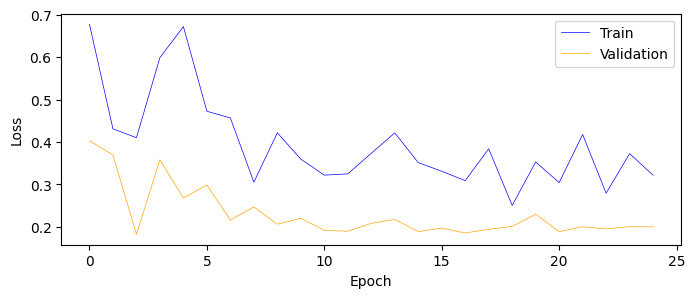

In [14]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

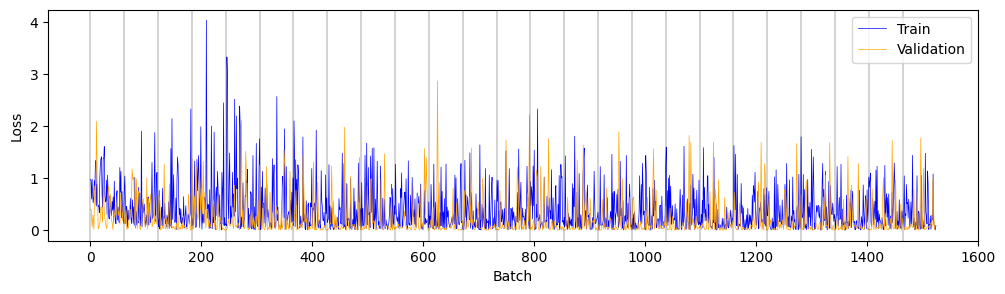

In [15]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(('Train','Validation'))

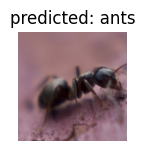

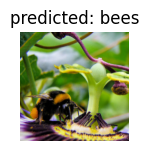

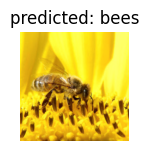

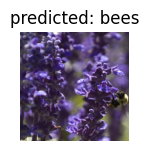

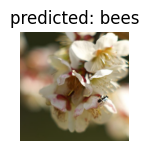

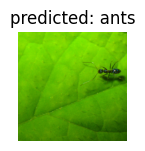

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

***
### Q2: Which of the two approaches worked best (in terms of validation accuracy)? Approach A or Approach B? Explain why you think this might be?

Approach A wins because every layer adapts to ants vs. bees. Approach B keeps most layers frozen, so it can't tune the features as well.
***

***
### Q3: Change the batch size from 16 to 32 and then re-run both model training runs. How does this change the training and performance?

With batch set to 32, that means half as many mini-batches per epoch, so there are less(fewer? I never know) training steps and loss curves look smoother. Accuracy stayed about the same.
***




***
### Q4: Change the batch size from 32 to 4 and then re-run both model training runs. How does this change the training and performance?  Also comment on whether there are now more or less mini-batches.

When batch is set to 4 creates 8 times more mini-batches than when batch is set to 32, so epochs take longer. The extra updates make training noisier(A lot more) loss curves get bumpier, but validation accuracy stays roughly similar. I haven't read ahead on the questions but I think I see where this is going.
***

***
### Q5: Look at the loss curves when the batch size was 32 and compare them to when the batch size of 4. For which batch size were the loss curves more bumpy or jagged? Explain why this is?  

The loss curves with when batch eauls 4 were much bumpier. Tiny batches give noisy gradient estimates, so each step jitters/jumps/shifts more. When the batch equals 32 averages gradients over more samples, smoothing the curve.
***

Inference on one Images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [17]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

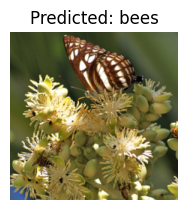

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='CS3120/lab4_transfer_learning_images/hymenoptera/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

# Butterfly isn't far off